<a href="https://colab.research.google.com/github/intelligenxe/LSTM-CNN-GRU-time-series/blob/main/Microsoft_Stock_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MICROSOFT STOCK FORECASTING WITH LSTM

https://www.youtube.com/watch?v=CbTU92pbDKw  (youtube video where the original version of this tutorial is explained)


## LOADING AND PREPROCESSING THE STOCK PRICE DATA

In [ ]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

Download CSV from Yahoo.com and upload it unto this notebook

In [ ]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063504,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400
...,...,...,...,...,...,...,...
9498,2023-11-17,373.609985,374.369995,367.000000,369.850006,369.850006,40157000
9499,2023-11-20,371.220001,378.869995,371.000000,377.440002,377.440002,52465100
9500,2023-11-21,375.670013,376.220001,371.119995,373.070007,373.070007,28423100
9501,2023-11-22,378.000000,379.790009,374.970001,377.850006,377.850006,23345300


In [ ]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9498,2023-11-17,369.850006
9499,2023-11-20,377.440002
9500,2023-11-21,373.070007
9501,2023-11-22,377.850006


In [ ]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9498    2023-11-17
9499    2023-11-20
9500    2023-11-21
9501    2023-11-22
9502    2023-11-24
Name: Date, Length: 9503, dtype: object

Convert dtype from string to datetime

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9498,2023-11-17,369.850006
9499,2023-11-20,377.440002
9500,2023-11-21,373.070007
9501,2023-11-22,377.850006


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-15-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9498   2023-11-17
9499   2023-11-20
9500   2023-11-21
9501   2023-11-22
9502   2023-11-24
Name: Date, Length: 9503, dtype: datetime64[ns]

Replace index number with date

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-11-17,369.850006
2023-11-20,377.440002
2023-11-21,373.070007


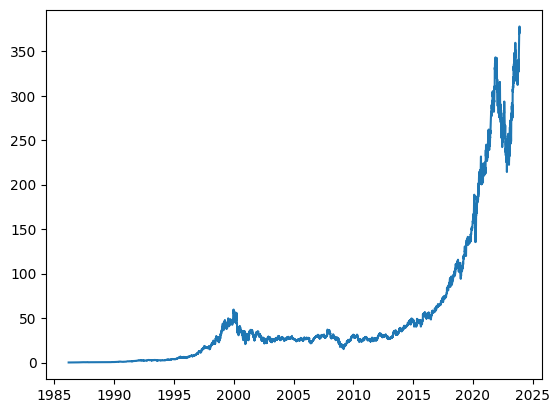

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

Change dataframe to a sequence shape more suitable for training:

Target Date
Input:  Target-3	Target-2	Target-1
Output: Target

This converts into into a supervised problem

## CASE 1: TRAINING THE MODEL WITH A LONG TERM RANGE

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day first time around: '1986-03-18'
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '1986-03-18',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9074,2022-03-17,276.440002,287.149994,294.390015,295.220001
9075,2022-03-18,287.149994,294.390015,295.220001,300.429993
9076,2022-03-21,294.390015,295.220001,300.429993,299.160004
9077,2022-03-22,295.220001,300.429993,299.160004,304.059998


Convert this into a numpy array so we can fit it into a TensorFlow model

X is a 3 dimentinal input tensor

y is the output vector

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9079,), (9079, 3, 1), (9079,))

Split into training, validation and test data

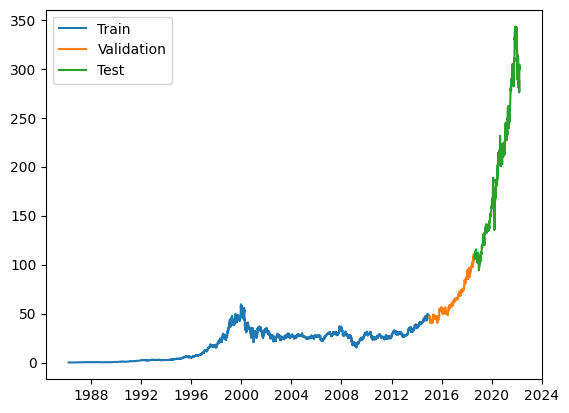

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

Training the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), # because you use 3 dates in the past and 1 because it is univariate forcasting
                    layers.LSTM(64),  # we arbitrarily use 64 neurons for the LSTM, the bigger the number the more prone to overfitting and more heavy duty
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])   # this is a linear layer as it does not have activation function

model.compile(loss='mse',  # the loss function will minimize the mse (mean square error)
              optimizer=Adam(learning_rate=0.001), # you can optimize this hyperparameter as well as the 64 and 32 above
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
227/227 [==============================] - 5s 8ms/step - loss: 99.2357 - mean_absolute_error: 4.4273 - val_loss: 503.0869 - val_mean_absolute_error: 15.2423
Epoch 2/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3843 - mean_absolute_error: 0.3475 - val_loss: 390.9178 - val_mean_absolute_error: 12.5722
Epoch 3/100
227/227 [==============================] - 2s 8ms/step - loss: 0.3261 - mean_absolute_error: 0.3343 - val_loss: 342.2347 - val_mean_absolute_error: 11.4099
Epoch 4/100
227/227 [==============================] - 2s 10ms/step - loss: 0.3240 - mean_absolute_error: 0.3325 - val_loss: 320.5325 - val_mean_absolute_error: 10.9900
Epoch 5/100
227/227 [==============================] - 2s 7ms/step - loss: 0.3013 - mean_absolute_error: 0.3210 - val_loss: 299.3675 - val_mean_absolute_error: 10.3748
Epoch 6/100
227/227 [==============================] - 1s 6ms/step - loss: 0.3045 - mean_absolute_error: 0.3274 - val_loss: 288.8358 - val_mean_absolute_error

KeyboardInterrupt: ignored

The above run was not converging so it was stopped

227/227 [==============================] - 1s 2ms/step


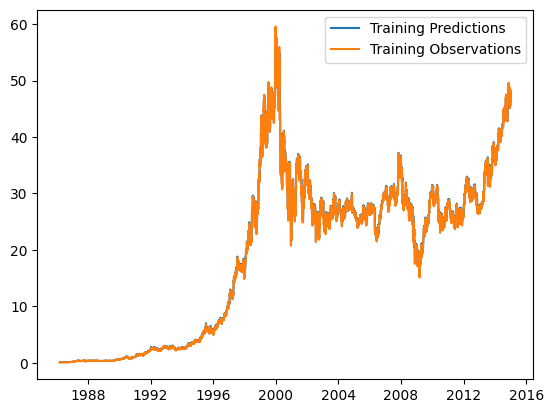

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

29/29 [==============================] - 0s 2ms/step


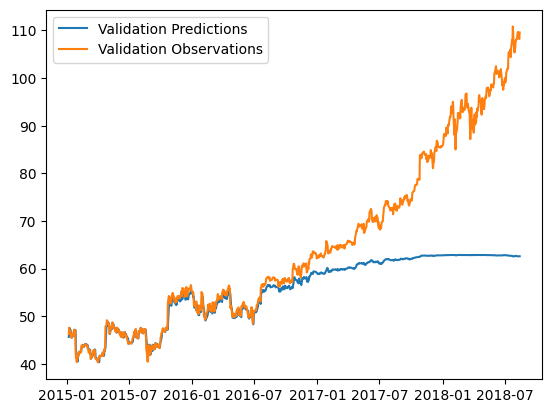

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

29/29 [==============================] - 0s 4ms/step


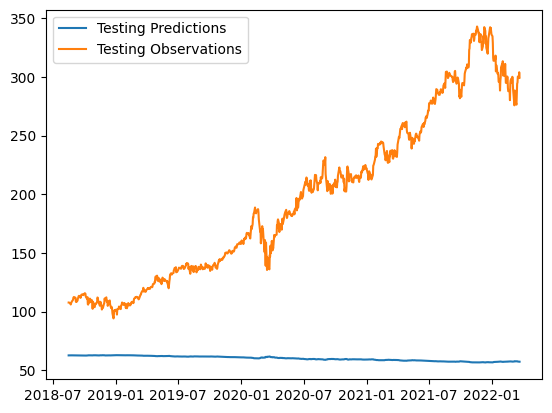

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

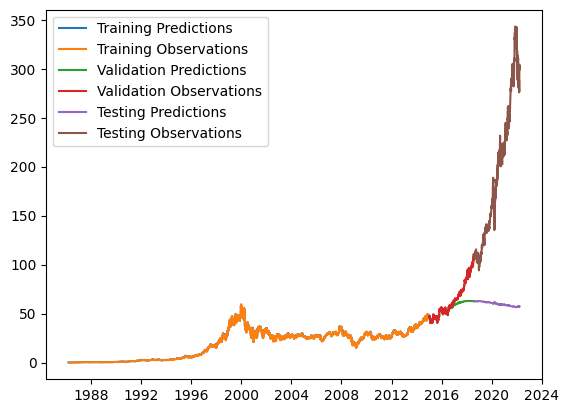

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Above we see that for

Training we use the last 3 real values (orange) to predict the next target value (blue). Likewise,
for Validation we use the model to make predictions (green), and finally for testing we use the model to make prediction (purple), and we also show the real observations in red and brown, respectively. So we can see that LSTM are very bad in making far out extrapolations, all the training from 1988 to 2015 did not help. So maybe we should just use the latest range to train (for example, starting with March 25 2021).

##CASE 2: TRAINING THE MODEL WITH THE MOST RECENT RANGE ONLY



(First time around vs Second time around)  It is important to note that below we use the exact same code, the only thing that we change is the Start day.

In [ ]:
# Start day first time around: '1986-03-18'
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


Convert this into a numpy array so we can fit it into a TensorFlow model

X is a 3 dimentinal input tensor

y is the output vector

In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

Split into training, validation and test data

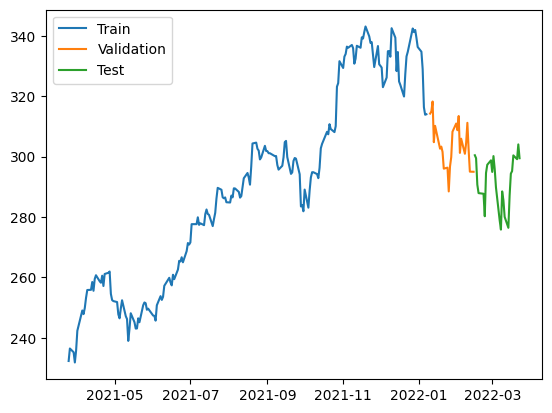

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

It is important to note in the above real data that the y ranges for the validation and testing the model has already seen previously in the training ranges, whereas in the Case 1 of the larger range above, the model did not know what to do with the very high y values of validation and testing because during training it had not seen those before.

Training the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), # because you use 3 dates in the past and 1 because it is univariate forcasting
                    layers.LSTM(64),  # we arbitrarily use 64 neurons for the LSTM, the bigger the number the more prone to overfitting and more heavy duty
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])   # this is a linear layer as it does not have activation function

model.compile(loss='mse',  # the loss function will minimize the mse (mean square error)
              optimizer=Adam(learning_rate=0.001), # you can optimize this hyperparameter as well as the 64 and 32 above
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 103ms/step - loss: 84409.9688 - mean_absolute_error: 288.7891 - val_loss: 92003.7500 - val_mean_absolute_error: 303.2339
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 84043.7188 - mean_absolute_error: 288.1563 - val_loss: 91627.5391 - val_mean_absolute_error: 302.6129
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 83663.7812 - mean_absolute_error: 287.4955 - val_loss: 91167.4297 - val_mean_absolute_error: 301.8517
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 83166.6172 - mean_absolute_error: 286.6323 - val_loss: 90537.5000 - val_mean_absolute_error: 300.8065
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 82542.8047 - mean_absolute_error: 285.5423 - val_loss: 89871.5938 - val_mean_absolute_error: 299.6976
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 81898.6250 - mean_absolute_error: 284.4078 - val_loss: 89127.

7/7 [==============================] - 1s 4ms/step


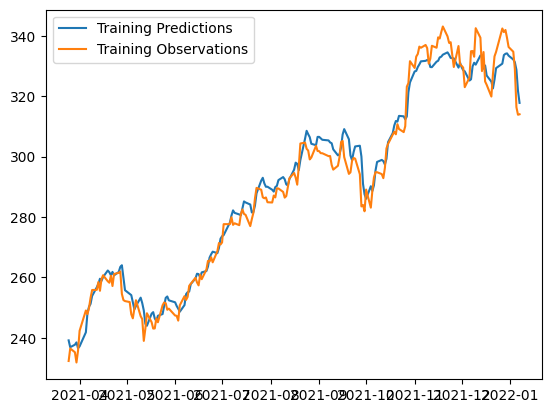

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


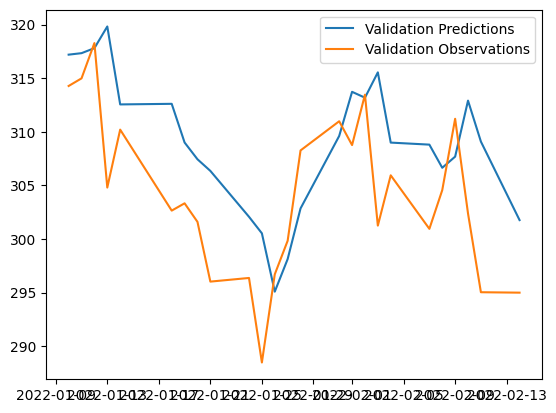

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 21ms/step


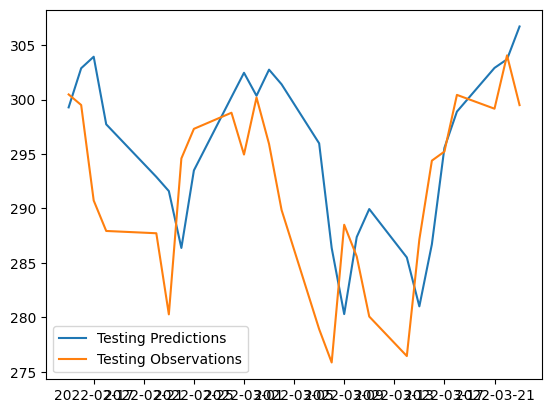

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

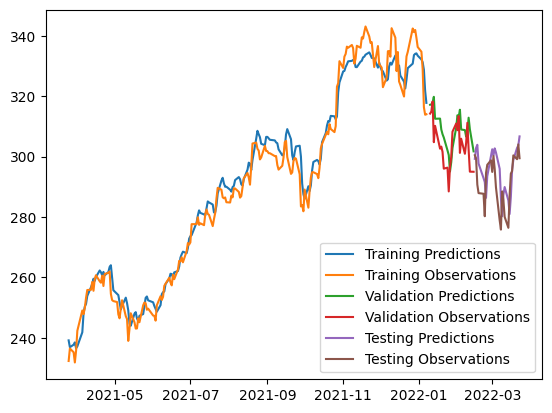

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Above we see that for

Training we use the last 3 real values (orange) to predict the next target value (blue). Likewise,
for Validation we use the model to make predictions (green), and finally for testing we use the model to make prediction (purple), and we also show the real observations in red and brown, respectively. So we can see that LSTM are very bad in making far out extrapolations, all the training from 1988 to 2015 did not help. But in this second attempt where we use the latest range to train (starting with March 25 2021) the results look much better.

IMPORTANT NOTE: IN ALL THESE RANGES (TRAINING, VALIDATION AND TESTING) WE USE THE 3 PREVIOUS ACTUAL/REAL VALUES TO MAKE THE PREDICTION OF THE TARGET VALUE

## CASE 3: PREDICTING FAR OUT WHERE NO KNOWN DATA IS AVAILABLE

LET'S SEE WHAT HAPPEN IF YOU WHAT TO PREDICT THE FUTURE BUT YOU NO LONGER HAVE (SAY 3) PREVIOUS REAL VALUES BECAUSE YOU ARE VARIOUS STEPS IN THE FUTURE. SO WE TRAIN UP TO THE LAST REAL VALUE AND TRY TO RECURSEVELY PREDICT THE FUTURE

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 21ms/step


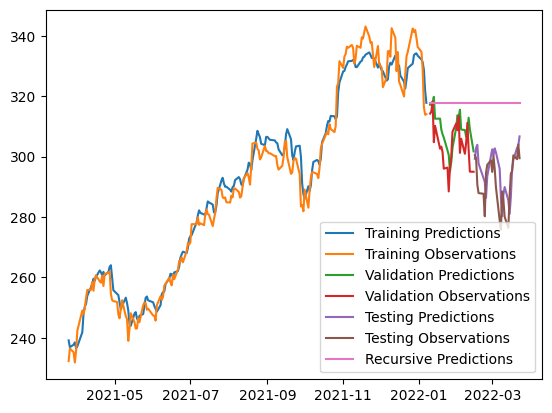

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

The prediction in this case is flat, so LSTM are not good for long term prediction, they are mostly good to know what the stock will do in the next training day - so LSTM is mostly good for the MICRO scale